# SDOF system with energy dissipation based upon snap-back mechanisms

In [69]:
%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [70]:
def model(z , t , M , C , K , sismo):
    """
    z would be the solution vector
    dzdt stores the system of ODEs ready for integration.
    """
    U = z[0]
    V = z[1]
    f_t  = inertial(M , sismo , t)
    dUdt = V
    dVdt = (1/M)*(f_t - C*V - K*U)
    dzdt = [dUdt , dVdt]
    
    return dzdt

In [71]:
def inertial(M , sismo , t ):
    """
    Computes the inertial force using interpolation
    based on the original time signal
    
    """
    ndats = len(sismo)
    t_max = (ndats-1)*0.02
    tt  = np.linspace(0 , t_max , ndats)
    accel = interp1d(tt , sismo)
    accel_new = accel(t)    
    f_t =-M*accel_new
    return f_t

In [72]:
def misses(F_0 , fac , lmda , x):
    """
    Constitutive law for the Misses truss. This is a piecewise
    continuous function according to fac.
    F_0 : force amplitude
    fac : number of wavelengths at which the constant slope phase starts
    lmda: Wavelength
    x   : Displacement
    """
    dx = lmda/100
    df = F_0*np.sin((2*np.pi/lmda)*dx)
    k = df/dx
    if x > -fac*lmda and x < fac*lmda:
        F = F_0*np.sin((2*np.pi/lmda)*x)
    else:
        if x<= -fac*lmda:
            F = k*(x + fac*lmda)
        else:
            F = k*(x - fac*lmda)
    return F

In [73]:
def dissip_device(z , t , M , C , K , sismo , m , c , k , F_0 , fac , lmda):
    """
    z would be the solution vector
    dzdt stores the system of ODEs ready for integration.
    """
    U = z[0]
    V = z[1]
    u = z[2]
    v = z[3]
#
    F_AP  = inertial(M , sismo , t)
    F_VM  = misses(F_0 , fac , lmda ,U-u)
#
    dUdt = V
    dVdt = (1/M)*(F_AP - C*V - K*U-F_VM)
    dudt = v
    dvdt = (1/m)*(F_VM - k*u - c*v)
#
    dzdt = [dUdt , dVdt , dudt , dvdt]
    
    return dzdt

In [74]:
sismo = np.loadtxt('medellin.txt')
ndats = len(sismo)
t_max = (ndats-10)*0.02
sismo = sismo*9.8
t     = np.linspace(0 , t_max , ndats)

## (1)-Simple sdof oscillator

Consider the following reference oscillator:

<center><img src="img/reference.png" alt="Picture1.png" style="width:400px"></center>

with natural frequency:

$$\omega^2=\frac{K_B}{M_B}$$

and with governing ODE

$$M_B\ddot U(t)+C_B\dot U(t)+K_BU(t)=-M_B \ddot U_G$$

Performing the change of variables we convert the 2-nd order ODE into a system of first order ODEs:

$$\dot U_B(t)= V_B(t)$$

$$\dot V_B(t)=\frac1M_B \lbrack -M_B \ddot U_G-C_BV_B(t)-K_BU_B(t)\rbrack .$$

#######################################################

Stiffness for the reference system = 52.158036206047605

#######################################################


<IPython.core.display.Javascript object>


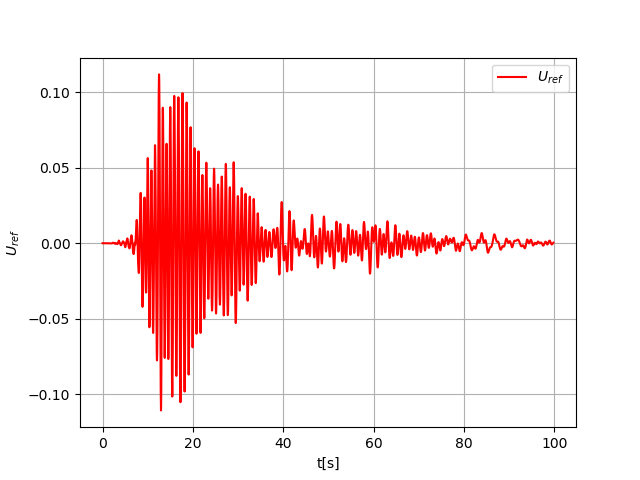

In [75]:
# System parameters
#
M_B   = 1.0                            #Building mass
C_B   = 0.2                            #Building dashpot coefficient
T     = 0.87                           #Natural period
K_B   = ((2*np.pi/T)**2)*M_B           #Building stiffness
print('#######################################################')
print()
print ('Stiffness for the reference system =' , K_B)
print()
print('#######################################################')
#
y0 = [0.0 , 0.0]                       # Initial conditions
t  = np.linspace(0 , t_max , ndats)    #Time span
#
#------Integrate---------
#
sol  = odeint(model , y0 , t , args=(M_B , C_B , K_B , sismo))
#
#------Plot---------
#
plt.figure(0)
U_ref = sol[:, 0]
plt.plot(t, U_ref , 'r', label='$U_{ref}$')
plt.legend(loc='best')
plt.ylabel('$U_{ref}$')
plt.xlabel('t[s]')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


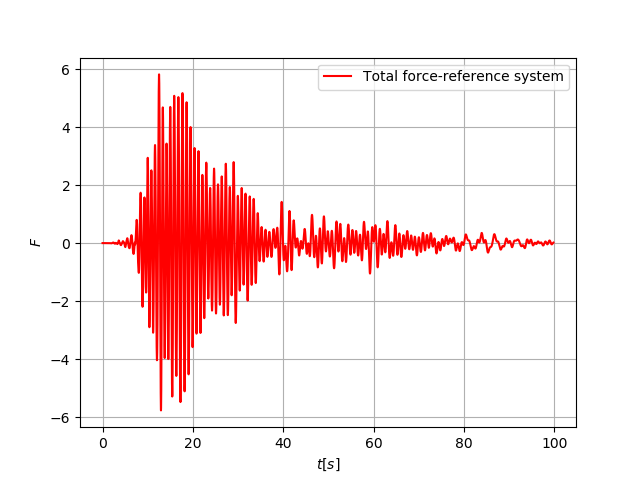

In [76]:
plt.figure(1)
V_ref = sol[: , 1]
F_r = K_B*U_ref + C_B*V_ref
plt.plot(t , F_r , 'r', label='Total force-reference system')
plt.legend(loc='best')
plt.xlabel('$t[s]$')
plt.ylabel('$F$')
plt.grid()
plt.show()

##  (2) The Misses truss

<center><img src="img/truss.png" alt="Picture1.png" style="width:200px"></center>

Consider the following device parameters:

- $K_s$   :    Spring stiffness
- $K_{VM}$: Stiffness of the linear region in the constitutive law for the Misses truss.
- $K_D$   : Effective stiffness of the truss-spring device given by:

$$K_D=\left(\frac1{k_s}-\frac1{K_{VM}}\right)^{-1}$$

where:

$$K_{VM}=\frac{2\mathrm\pi}\lambda F_0$$

In [86]:
#
# Misses truss parameters
#
U_max = 0.05
lmda  = 2.0*U_max              #Wavelength for the Misses truss F-d relationship
F_0   = 2.0                   #Force amplitude for the Misses truss
K_VM  = (2.0*np.pi/lmda)*F_0
print('#######################################################')
print()
print('Wavelength in the Misses truss =' , lmda)
print('Stiffness in the Misses truss =' , K_VM)
print()
print('#######################################################')
#
fac   = 1.0                                 #Piecewise continous at fac*lambda
#
x  = np.linspace(-2*lmda , 2*lmda, ndats)   #Assumed displacements span
n = len(x)
FM = np.zeros(n)
#
for i in range(n):
    FM[i] = misses(F_0 , fac , lmda , x[i])

#######################################################

Wavelength in the Misses truss = 0.1
Stiffness in the Misses truss = 125.66370614359172

#######################################################


<IPython.core.display.Javascript object>


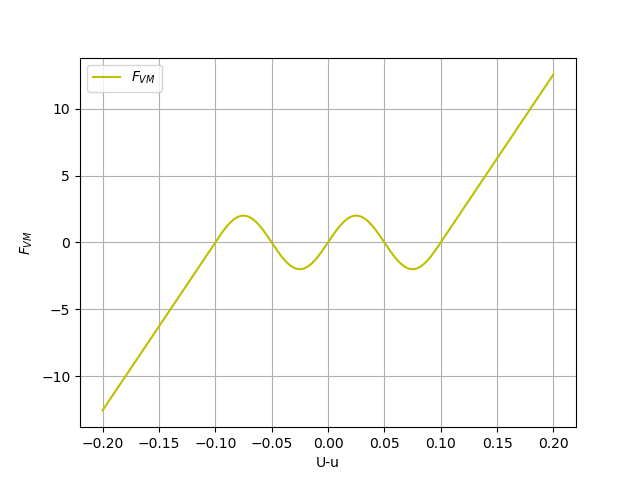

In [87]:
plt.figure(2)
plt.plot(x , FM , 'y', label='$F_{VM}$')
plt.legend(loc='best')
plt.xlabel('U-u')
plt.ylabel('$F_{VM}$')
plt.grid()
plt.show()

## (3) System with added device

<center><img src="img/dispositivo.png" alt="Picture1.png" style="width:500px"></center>

The dissipation device corresponds to a Misses truss with a spring of stiffness $k_s$

For the oscillator we have:

$$M_B\ddot{U}_B+ \widehat C_B\dot U_B\;+ \widehat K_BU_B+F_{VM}(U_B-u)=-M_B \ddot U_G$$

and for the device:

$$m\ddot u\;+\widehat c _s\dot u\;+k_su-F_{VM}(U_B-u)=0$$

### Effective stiffness of the device $K_D$

Definig the spring stiffness as a factor of the reference stiffness

$$K_s=fK_B$$

we have for the device

$$K_D=\left(\frac1{k_s}-\frac1{K_{VM}}\right)^{-1}$$

### Properties for equivalent systems

In order to have equivalence (in the natural frequency) between the reference system and the system with added device and assuming a constant mass we must have:

$${\widehat K}_B = K_B-K_D$$

In [88]:
pf  = 0.5       
k_s = pf*K_B                #Spring in the Misses truss
K_D =(k_s*K_VM)/(K_VM-k_s)  #Device stiffness
K_hat = K_B - K_D           #Modified building stiffness
C_hat = C_B/2
m   = 1.0e-3                #Device fictitious mass
c_s   = C_B/2               #Device inherent damping
print('#######################################################')
print()
print('Stiffness of the modified system K_hat =' , K_hat )
print('Stiffness of the added device K_D =' , K_D )
print('Spring stiffness k_s =' , k_s)
print('Stiffness of the reference system K_B =' , K_hat + K_D)
print()
print('#######################################################')

#######################################################

Stiffness of the modified system K_hat = 19.249502455590296
Stiffness of the added device K_D = 32.90853375045731
Spring stiffness k_s = 26.079018103023802
Stiffness of the reference system K_B = 52.158036206047605

#######################################################


In [89]:
y0 = [0.0 , 0.0 , 0.0 , 0.0]
#
#------Integrate---------
#
sol  = odeint(dissip_device , y0 , t ,  args =(M_B , C_hat , K_hat , sismo , m , c_s , k_s , F_0 , fac , lmda))

In [90]:
plt.figure(5)
U_dev = sol[:, 0]
plt.plot(t, U_dev , 'y', label='$U_{device}$')
plt.plot(t, U_ref , 'r', label='$U_{ref}$')
plt.legend(loc='best')
plt.xlabel('t[s]')
plt.ylabel('U')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

### Time history of forces in the reference system and system with added device

<IPython.core.display.Javascript object>


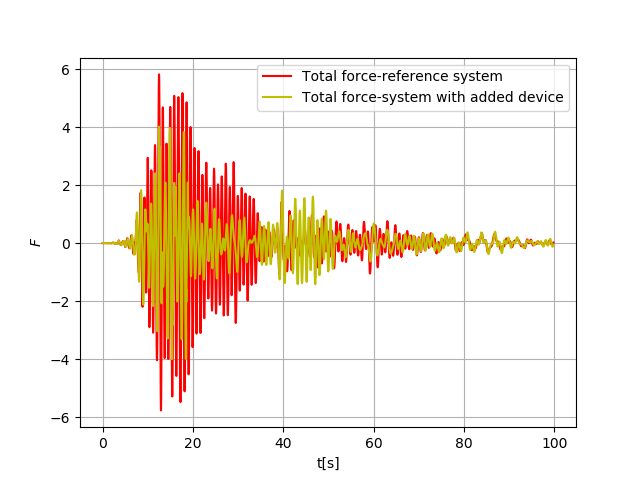

In [91]:
plt.figure(6)
V_dev = sol[: , 1]
u_dev = sol[: , 2]
v_dev = sol[: , 3]
F_w = K_hat*U_dev + C_hat*V_dev + k_s*u_dev + c_s*v_dev
plt.plot(t , F_r , 'r', label='Total force-reference system')
plt.plot(t , F_w , 'y', label='Total force-system with added device')
plt.legend(loc='best')
plt.xlabel('t[s]')
plt.ylabel('$F$')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


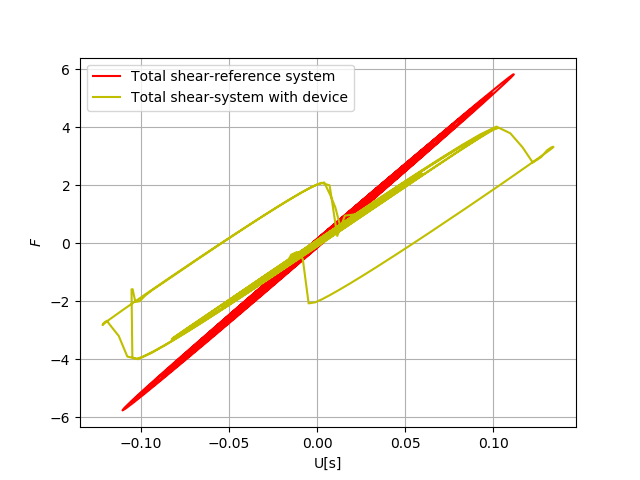

In [92]:
plt.figure(8)
plt.plot(U_ref , F_r , 'r', label='Total shear-reference system')
plt.plot(U_dev , F_w , 'y', label='Total shear-system with device')
plt.legend(loc='best')
plt.xlabel('U[s]')
plt.ylabel('$F$')
plt.grid()
plt.show()

In [93]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()